# Tutorial to retrieve TOD & HWP angle via sa_pipeline

### Import general libraries

In [96]:
import os
import sys
import numpy as np
topdir = os.environ['PWD']
sys.path.append(os.path.join(os.path.dirname(topdir), '')) # Add top directory
print(topdir)
# plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
# inline non-interactive mode
# python kernel check
print(sys.executable)
print(sys.version)

/home/cmb/sadachi/analysis_2021
/sw/cmb/polarbear/opt-202008/bin/python3
3.8.5 (default, Aug 21 2020, 00:19:38) 
[GCC 9.3.0]


### Data run ID & time setting

In [3]:
runID = 22300609
subID = 0
start = "20210205_174900";
end   = "20210205_175900";

### Get G3Time of start/end time

In [4]:
from spt3g import core
start_mjd = None if start==None else core.G3Time(start).mjd;
end_mjd   = None if end  ==None else core.G3Time(end  ).mjd;

print(f'{start} = {start_mjd}')
print(f'{end} = {end_mjd}')

20210205_174900 = 59250.742361111115
20210205_175900 = 59250.74930555555


###  Import simons_array_offline_software

In [17]:
sys.path.append(os.path.join(os.path.dirname(topdir), './library/simons_array_offline_software'))
# major pipeline libraries
import simons_array_python.sa_pipeline_inputs as sa_pi;
import simons_array_python.sa_observation as sa_ob;
import simons_array_python.sa_pipeline_filters as sa_pf;
# operator of time clip
import simons_array_python.sa_timestream_operators as sa_op;
# HWP angle calculator
import simons_array_python.sa_hwp as sa_hwp;

### Get detector list

In [7]:
num_bolo = 1
#num_bolo = 10
#num_bolo = None # All bolos
all_detectors = sa_op.gen_bolo_list()[:num_bolo] if num_bolo is not None else sa_op.gen_bolo_lis() # Only 1 bolos
print(f'all_detectors {all_detectors} ({len(all_detectors)} bolos)');

all_detectors ['13.13_15.90T'] (1 bolos)


### Initialize observation (data class)

In [11]:
print('initialize observation')
observation_tuple = (runID,subID);
ob = sa_ob.Observation(observation_tuple)
ob.detectors = all_detectors
ob.load_metadata()

initialize observation


### Initialize pipeline & operator to populate tod_list

In [13]:
print('dataload operation')
pi = sa_pi.InputLevel0CachedByObsID(all_detectors=all_detectors, n_per_cache=len(all_detectors), 
        load_g3=True, load_gcp=True,
        load_slowdaq=True, load_hwp=True, 
        load_dets=True, ignore_faulty_frame=True, record_frame_time=True);
op_dataload = sa_pf.OperatorDataInitializer(pi)
op_dataload.filter_obs(ob)

dataload operation
INFO: instantiating g3 data buffer from None
Loading data from g3 files for run_id=22300609, run_subid=0 . . . 
INFO: Run22300609.0: reading following files: Run22300609_000.g3,Run22300609_001.g3,Run22300609_002.g3,Run22300609_003.g3,Run22300609_004.g3.
INFO: Run22300609.0: frame (total, first, last)=(91, 2, 89).
Setting input name to data
Loading data from slowdaq files for run ID 22300609, run_subid 0 . . . 


### Operator to clip the tod by time

In [15]:
print('time clip operation')
op_timeclip = sa_pf.OperatorClipBeginEnd(begin_mjd=start_mjd, end_mjd=end_mjd)
op_timeclip.filter_obs(ob)

time clip operation
INFO: for Run 22300609.0, clipping points are (88762,180316).  Length: 408965 --> 91554.
len_timestream = 3, total_len=408965, key=_tod_unit
len_timestream = 0, total_len=408965, key=frame_faulty
len_timestream = -1, total_len=408965, key=frame_total
len_timestream = 4, total_len=408965, key=input_name
len_timestream = 56575800, total_len=408965, key=whwp_clk_cnts
len_timestream = 56575800, total_len=408965, key=whwp_encoder_cnts
len_timestream = 5415, total_len=408965, key=whwp_clk_cnts_at_ref
len_timestream = 5415, total_len=408965, key=whwp_encoder_cnts_at_ref
len_timestream = 2707, total_len=408965, key=whwp_irig_start_clk_cnts
len_timestream = 2707, total_len=408965, key=whwp_irig_start_times_mjd
len_timestream = 80, total_len=408965, key=frame_antenna_time_mjd
len_timestream = 267800, total_len=408965, key=raw_acu_seq
len_timestream = 267800, total_len=408965, key=raw_az_pos
len_timestream = 267800, total_len=408965, key=raw_az_command
len_timestream = 267800,

### Operator for HWP angle

In [18]:
print('HWP angle calculation')
op_hwp = sa_hwp.HWPAngleCalculator(encoder_reference_angle=0.)
op_hwp.filter_obs(ob)

HWP operation
Raw diff : median  768.0  , max  946  , min  590
Raw diff : median  5.0  , max  4294901766  , min  3
[]
Overflow increment fail search, clk counts
Overflow increment fail search, clk counts @ ref
Overflow increment fail search, IRIG clk counts
5415 5415
5415 5415
Number of overflows in TOD 4131.0 Expected time 2707.2921600000004 Real time 600.0017407815903
Find approximate encoder count sample rate 20930.63984405458
Number of ok ref holes 4735


### Print TOD data

In [36]:
print(ob)
tod = ob.tod_list[0];
print(tod, len(ob.tod_list))
print('keys',tod.cache.keys());
def printlist(list_data, list_name): print(f'{list_name} (size:{len(list_data)}) = {list_data}');
printlist(tod.read_times(), 'times');
printlist(tod.read('bolo_time'), 'bolo_times');
printlist(tod.read('raw_antenna_time_mjd'), 'raw_antenna_time_mjd');
printlist(tod.read('raw_az_pos'), 'raw_az_pos');
printlist(tod.read('13.13_15.90T-I'), 'TOD (13.13_15.90T-I)');
printlist(tod.read('hwp_angle'), 'HWP angle');

<simons_array_python.sa_tod.TOD object at 0x7fbf908f8850> 1
keys dict_keys(['_tod_unit', 'frame_faulty', 'frame_total', 'input_name', 'whwp_clk_cnts', 'whwp_encoder_cnts', 'whwp_clk_cnts_at_ref', 'whwp_encoder_cnts_at_ref', 'whwp_irig_start_clk_cnts', 'whwp_irig_start_times_mjd', 'frame_antenna_time_mjd', 'bolo_time', 'bolo_G3Time', 'raw_acu_seq', 'raw_az_pos', 'raw_az_command', 'raw_az_rate', 'raw_az_rate_command', 'raw_el_pos', 'raw_el_command', 'raw_el_rate', 'raw_el_rate_command', 'raw_in_control', 'raw_scan_flag', 'raw_state', 'raw_antenna_time_mjd', '13.13_15.90T-I', '13.13_15.90T-Q', 'hwp_ref_num_problem_samples', 'hwp_encoder_gap_indices', 'hwp_encoder_gap_times', 'hwp_angle'])
times (size:91554) = [59250.74236113 59250.74236121 59250.74236128 ... 59250.74930545
 59250.74930552 59250.7493056 ]
bolo_times (size:91554) = [59250.74236113 59250.74236121 59250.74236128 ... 59250.74930545
 59250.74930552 59250.7493056 ]
raw_antenna_time_mjd (size:267800) = [59250.73562836 59250.73562

### Plot TOD data 

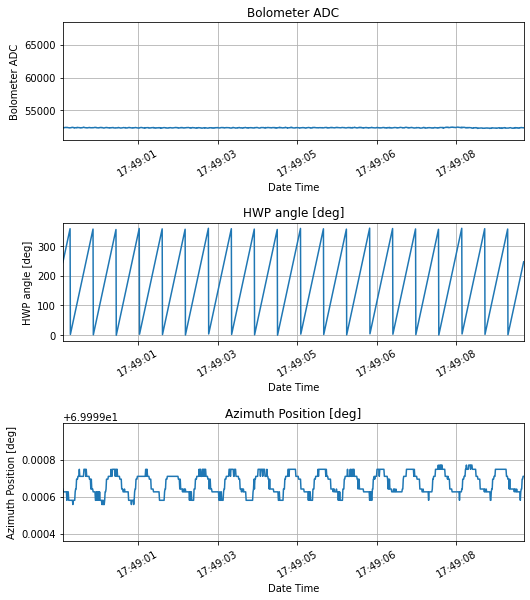

In [110]:
# Get data arrays
time = tod.read('bolo_time')
antenna_time = tod.read('raw_antenna_time_mjd')
bolo_data = tod.read('13.13_15.90T-I')
az_pos = tod.read('raw_az_pos')
hwp_angle = tod.read('hwp_angle')

# Convert
hwp_angle = hwp_angle * 180./np.pi # rad --> deg
az_pos = az_pos * 180./np.pi # rad --> deg

# Make figure (Nrow)
Nrow = 3; 
fig, axs = plt.subplots(Nrow,1);
fig.set_size_inches(8*1,4*Nrow);
plt.subplots_adjust(wspace=0.5, hspace=0.7, left=0.15, right=0.95,bottom=0.20, top=0.80)
    
# Bolometer TOD
ax = axs[0]
ax.plot(time, bolo_data, label='bolometer')
ax.grid(True)
ax.set_xlabel('Date Time')
ax.set_ylabel('Bolometer ADC')
ax.set_title('Bolometer ADC')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.tick_params(axis='x',labelrotation=30,labelsize=10);

#  HWP angle
ax = axs[1]
ax.plot(time, hwp_angle, label='HWP angle')
ax.grid(True)
ax.set_xlabel('Date Time')
ax.set_ylabel('HWP angle [deg]')
ax.set_title('HWP angle [deg]')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.tick_params(axis='x',labelrotation=30,labelsize=10);

# Azimuth position
ax = axs[2]
ax.plot(antenna_time, az_pos, label='bolometer')
ax.grid(True)
ax.set_xlabel('Date Time')
ax.set_ylabel('Azimuth Position [deg]')
ax.set_title('Azimuth Position [deg]')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.tick_params(axis='x',labelrotation=30,labelsize=10);


# Zoom-in a narrow time range
def sec_to_mjd(sec): return sec * 1./(60.*60.*24) # 1 mjd = 1 day
sec_span = 10; # sec
t_start = time[0]
t_end   = time[0]+sec_to_mjd(sec_span)
for ax in axs: ax.set_xlim(t_start, t_end);